In [1]:
import pandas as pd
import numpy as np
from wft import fetch_yf_data, WalkForward, asses_perf
from wft import Visualization as vis
def compute_atr(high: pd.Series, low: pd.Series, close: pd.Series, period: int = 14) -> pd.Series:
    # Calculate the True Range (TR)
    high_low = high - low
    high_close_prev = (high - close.shift()).abs()
    low_close_prev = (low - close.shift()).abs()

    tr = pd.concat([high_low, high_close_prev, low_close_prev], axis=1).max(axis=1)

    # Calculate the ATR
    atr = tr.ewm(span=period, min_periods=1, adjust=False).mean() 
    return atr

def compute_indipendet_variables(ohlc: pd.DataFrame, lookahead:int = 1) -> pd.DataFrame:
    # data is already in log form
    open   = ohlc['Open']
    close  = ohlc['Close']
    low    = ohlc['Low']
    high   = ohlc['High']
    volume = ohlc['Volume']

    weekly_atr = compute_atr(high , low , close , 5)
    monthly_atr = compute_atr(high , low , close , 21)

    upper  = high - np.maximum(close , open)
    lower   = np.minimum(close , open)  - low
    assymmetry = upper - lower
    Intraday_assymmetry_standardized = assymmetry/ ( assymmetry.ewm(span = 20, adjust= False).std())

    vol_mean20 = volume.ewm(span = 20, adjust= False).mean()
    vol_surprise = volume  / vol_mean20 -1
    vol_surprise/=vol_surprise.ewm(span = 20, adjust= False).std()

    return5_over_atr = close.diff(5)/monthly_atr 

    df = pd.DataFrame(index = ohlc.index)

    df['return5_over_atr'] = return5_over_atr
    df['Intraday_assymmetry']   = Intraday_assymmetry_standardized
    df['vol_surprise']   = vol_surprise

    target =  close.diff(lookahead).shift(-lookahead)/weekly_atr 
    df.iloc[:20] = np.nan
    target.iloc[:20] = np.nan
    return df, target

Final Model Example,

The indipendent variables and the target remain unchanged from the last examples,

Just a few additions are made to demonstrate the flexibility of the framework

Model 4:

    - Include Interaction terms (squares, cross products), resulting in 9 variables.
    - Perform Performs Principal Component Analysis (PCA) on these variables.
    - Select optimal number of principal components with a cross validation
    - OLS estimator will use the principal components as inputs variables

Estimated time: < 10s

p-value under H0: mean_return <=0 = 0.72 %
Mean Return: 0.086 %
Lower Confidence Interval: 0.03%
Upper Confidence Interval: 0.14%


c:\Users\andre\Desktop\VS-code_projects\Project\wft\plot_variables.py:237: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method = "ffill", inplace =True)


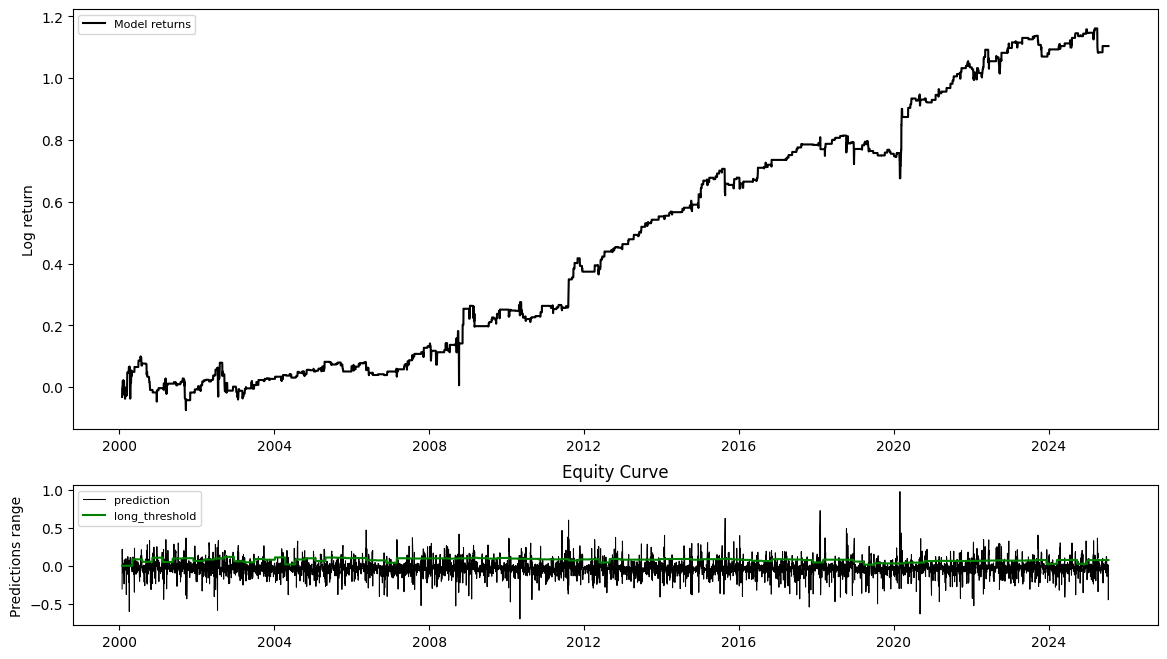

                                      mu_long_over_t  std_long  mu_long/std_long
return5_over_atr                           -1.889432  1.614585         -1.170228
Intraday_assymmetry                         0.290689  0.745136          0.390115
vol_surprise                                0.615581  1.003220          0.613605
return5_over_atr_squared                    6.176841  4.734119          1.304750
Intraday_assymmetry_squared                 0.639727  1.105262          0.578801
vol_surprise_squared                        1.385389  1.632970          0.848386
return5_over_atr_Intraday_assymmetry       -0.922988  2.219974         -0.415765
return5_over_atr_vol_surprise              -1.396230  3.050262         -0.457741
Intraday_assymmetry_vol_surprise            0.352512  1.088283          0.323916
       Annual Return %  Sharpe Ratio Annualized  Mean Return %  Total Return %  Max Drawdown %  Profit Factor  Sharpe Ratio benchmarck  P-value H0: mean_r <= 0  Time in the market %
Model   

In [ ]:
if __name__ == '__main__':
    data = fetch_yf_data('SPY')
    df,target = compute_indipendet_variables(data)
    ## Inititalize Pipiline Parameters
    inputs = df  # variables df
    targets = target  # target variable
    ohlc =data

    max_lookahead = 1
    model_components = ['pca', 'ols']
    preprocess_variables =  [ 'X','y']
    preprocess_type = ['standardize']
    model_kwargs ={'pca':{'n_components':2}, 'ols': {'add_intercept':True }}
    grid_hyperparams = []
    for i in range(1,4+1):   # Max 4 components in PCA, 4 may be too much, but it is a good starting point
            grid_hyperparams.append({'pca':{'n_components':i}, 'ols': {'add_intercept':True }})

    kwargs_cv = {'cv_folds': 10, 'eval_metric':'mae'}
    criterion = 'sharpe_ratio'
    min_trades = .1
    min_crit_value = 0
    WF = WalkForward(
                    inputs = inputs,
                    targets = targets,
                    ohlc = ohlc,
                    max_lookahead = max_lookahead,
                    model_components = model_components,
                    criterion = criterion,
                    min_trades = min_trades,
                    model_kwargs = model_kwargs,
                    min_crit_value = min_crit_value,
                    grid_hyperparams=grid_hyperparams,
                    kwargs_cv=kwargs_cv,
                    interaction_terms=True,
                    preprocess_variables = preprocess_variables,
                    preprocess_type = preprocess_type,
                    side = 'long',
                        )

    # Perform WalkForward
    start_train = 252*5
    train_size =   0 # All past data
    step_size = 22*3 # Retrain every 3  months 
    rets, long_stats, short_stats = WF.run(start_train= start_train,
                                           train_size = train_size,
                                           step_size=step_size, commision=0.0002)
    
    mean_ret = np.round(100*rets[rets!=0].mean(),3)
    p_value, ci = asses_perf.p_value_returns(rets.values)
    print(f'p-value under H0: mean_return <=0 = {(100*p_value):.2f} %')
    print(f'Mean Return: {mean_ret} %')
    print(f'Lower Confidence Interval: {(ci[0]):.2f}%')
    print(f'Upper Confidence Interval: {(ci[1]):.2f}%')  
    vis.plot_single_equity_curve(rets,WF.model, WF.inputs ,long_stats,short_stats  )
    threshold_dict = {'long': long_stats, 'short': short_stats}
    print(asses_perf.extrapolate_decision_model(WF.inputs, WF.model, threshold_dict).to_string())
    print(asses_perf.performance_table(rets, 'Model', data['Close'].diff().fillna(0), 252*5).to_string())

This final model shows no improvemnts to the ones of the previous examples,
The Principal Component Analysis in this case does not really make sense are out set of variable is small only 9, 
either way this was just for illustratory purposes

In [ ]:
avg_n_components = np.mean([name['pca']['n_components'] for name in long_stats['best_params_cv']])
print(f'Average number of PCA components used in the model: {avg_n_components}')
## The average number of PCA components used in the model is 3.6, which is pretty high for this small dataset


Average number of PCA components used in the model: 3.673469387755102
